<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />


# Perceptrón multicapa con Keras<a id="top"></a>

<i><small>Autor: Alberto Díaz Álvarez<br>Última actualización: 2023-02-23</small></i></div>
                                                  

***

## Introducción

Ya hemos visto una implementación casi desde cero de un perceptrón multicapa. Existen bibliotecas que abstraen muchos detalles de implementación y que nos ayudan a creear modelos útiles y complejos en apenas tiempo.

Nosotros vamos a ver una de estas bibliotecas, `keras`, a partir de ejemplos, y comenzaremos con el del perceptrón multicapa que implementamos en el anterior Notebook.

## Objetivos

Vamos a implementar un perceptrón multicapa similar al implementado anteriormente pero con las primitivas que nos ofrece la biblioteca `keras`. Esta implementación la realizaremos de dos formas diferentes para entender un poco mejor su funcionamiento. También veremos cómo se entrenan estos modelos, cómo se trabaja con optimizadores y con _callbacks_ y cómo salvar y cargar modelos para usarlos más adelante.

## Bibliotecas y configuración

A continuación importaremos las bibliotecas que se utilizarán a lo largo del _notebook_.

In [17]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd

Si salen algunos _warning_ es porque `tensorflow` es así. Seguramente sea una compilación genérica y requiera de una compilación específica para que desaparezcan. Afortunadamente, no suele pasar nada porque salgan estos warning, sobreviviremos.

Configuraremos también algunos parámetros para adecuar la presentación gráfica.

In [9]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (16, 9),'figure.dpi': 64})

***

## Conjunto de datos sobre el que trabajar

Ahora estamos trabajando con modelos que aprenden bajo un esquema de aprendizaje supervisado por lo que necesitamos un conjunto de datos con entradas y sus salidas esperadas de los que aprender.

Keras nos proporciona varios conjuntos de datos bajo el módulo `datasets`. De ellos vamos a usar el de `mnist`, que es un conjunto de imágenes pequeñas ($28 \times 28$ píxeles) con dígitos del 0 al 9 manuscritos.

![](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

Los _datasets_ del módulo ofrecen una función `load_data` para cargar los datos, descargándolos si es necesario. En el caso del `mnist`, los datos vienen separados en dos conjuntos, entrenamiento y test, en dos partes cada uno, entradas y salidas.

In [10]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print(f'Training shape: {x_train.shape} input, {y_train.shape} output')
print(f'Test shape:     {x_test.shape} input, {y_test.shape} output')

Training shape: (60000, 28, 28) input, (60000,) output
Test shape:     (10000, 28, 28) input, (10000,) output


Con los conjuntos de datos cargados y preparados, ya tenemos suficiente para trabajar. ¡Vamos allá!

## El API secuencial

La primera forma que vamos a ver para crear modelos en `keras` es su API secuencial. Es la más sencilla, ya que el modelo se crea como una lista de capas sucesivas y por debajo este las conecta (esto es, las salidas de una capa con las entradas de la siguiente). Por ejemplo, el perceptrón que implementamos anteriormente (bueno, lo más parecido a lo que podemos llegar) se implementaría como sigue:

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(3, activation='sigmoid', input_shape = [2,]),
    tf.keras.layers.Dense(2, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 3)                 9         
                                                                 
 dense_4 (Dense)             (None, 2)                 8         
                                                                 
 dense_5 (Dense)             (None, 1)                 3         
                                                                 
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


Esto sería únicamente la arquitectura. Para poder entrenarlo tendríamos que especificar de qué manera calculamos el error (en nuestro caso antes usábamos la diferencia entre valor esperado y valor inferido), qué optimizador (en nuestro caso usábamos _backpropagation_) y si queremos o no alguna métrica más (antes sacábamos exactitud y rmse).

In [12]:
model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.5),
    metrics = [tf.keras.metrics.Accuracy()]
)

Con esto podemos entrenar el modelo. Por ejemplo, en el problema de la puerta XOR de antes:

In [13]:
DATASET_XOR = np.array([
    [0, 0, 0],
    [0, 1, 1],
    [1, 0, 1],
    [1, 1, 0],
])
X = DATASET_XOR[:, :-1]  # Entradas: Todas las columnas hasta la última
y = DATASET_XOR[:, -1:]  # Salidas: Todas las columnas desde la última

model.fit(X, y, epochs=1000, verbose=0)
ŷ = model.predict(X)
np.piecewise(ŷ, [ŷ < 0.5, 0.5 <= ŷ], [0, 1])

1/1 [==============================] - 0s 84ms/step


array([[0.],
       [1.],
       [0.],
       [1.]], dtype=float32)

Ahora bien, con el conjunto de datos de `mnist` tenemos que hacer algunos cambios porque este modelo no nos vale:

1. La entrada es una matriz de $28 \times 28$, y hasta ahora hemos visto modelos que esperan un vector de entrada. Afortunadamente para esto último `keras` proporciona una capa denominada `Flatten` que aplana la entrada suministrada.
2. La salida de nuestro modelo no es 0 o 1. Es un valor del 0 al 10. Si fuese una clasificación binaria valdría, pero es una clasificación denominada "multiclase". Para estos casos, se suele trabajar con varias clasificaciones binarias, una para cada clase. Como tenemos 10 posibles valores de salida, usaremos 10 neuronas, una para cada clase, y como función de activación y loss usaremos dos funciones que trabajan juntas para hacer las labores de clasificación. Esto lo veremos más adelante; por ahora basta pensar que funcionan juntas en este tipo de problemas multiclase.
3. El learning_rate que se suele usar para empezar a entrenar modelos suele ser bajo, del orden de 0.1 o inferior. Usaremos los valroes por defecto de nuestro optimizador.
4. Existe una métrica más adecuada para nuestro cálculo del error que la simple exactitud.

Con estos cambios nuestro modelo quedaría como sigue:

In [14]:
model = tf.keras.models.Sequential([
    # La primera capa del modelo toma entradas de 28x28 y las "aplana"
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(3, activation='sigmoid'),
    tf.keras.layers.Dense(2, activation='sigmoid'),
    # La salida la cambiamos a 10 neuronas y una función de activación softmax
    tf.keras.layers.Dense(10, activation='softmax'),
])
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.SGD(),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 3)                 2355      
                                                                 
 dense_7 (Dense)             (None, 2)                 8         
                                                                 
 dense_8 (Dense)             (None, 10)                30        
                                                                 
Total params: 2,393
Trainable params: 2,393
Non-trainable params: 0
_________________________________________________________________


Es curioso ver cómo han cambiado los parámetros. De 2 entradas que teníamos antes a 768, con lo que ahora tenemos que ajustar 2393 parámetros en lugar de sólo 20. Bueno, veamos qué tal se comporta con el conjunto de entrenamiento de `mnist`

In [15]:
history = model.fit(x_train, y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 2.2687 - sparse_categorical_accuracy: 0.1692
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 2.1930 - sparse_categorical_accuracy: 0.1965
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 2.1042 - sparse_categorical_accuracy: 0.2063
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 2.0260 - sparse_categorical_accuracy: 0.2549
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 1.9585 - sparse_categorical_accuracy: 0.2676
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 1.9112 - sparse_categorical_accuracy: 0.3267
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 1.8650 - sparse_categorical_accuracy: 0.3438
Epoch 8/10
1875/1875 [==============================] - 2s 1ms/step - loss: 1.8260 - sparse_categorical_accuracy: 0.3465
Epoch 9/10
1875/1875 [==========

Como vemos, el método `fit` devuelve un objeto al que apuntará la variable `history`. Este objeto guarda un histórico de todos los indicadores de nuestro proceso de entrenamiento (incluidas las métricas especificadas en el método `compile`) _epoch_ por _epoch_. Podemos aprovechar este objeto para imprimir por pantalla la evolución del entrenamiento, lo que nos daría información acerca de cómo ha ido:

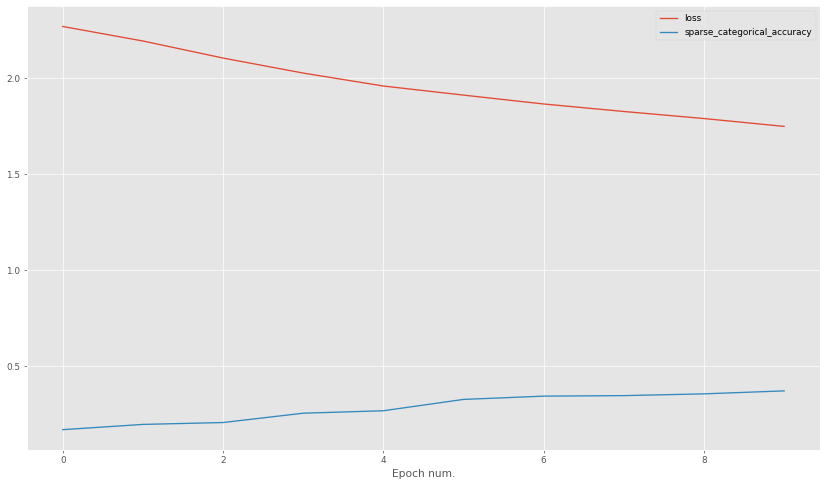

In [18]:
pd.DataFrame(history.history).plot()
plt.xlabel('Epoch num.')
plt.show()

Esta gráfica nos dice más o menos tres cosas:

1. El error (_loss_) va bajando durante el entrenamiento, cosa que está muy bien.
2. La exactitud (_accuracy_) va subiendo, cosa que también está muy bien.
3. La exactitud sigue siendo baja, por lo que queda mucho que entrenar.

Vamos a ver la evolución de los indicadores con unos cuantos _epochs_ más de entrenamiento.

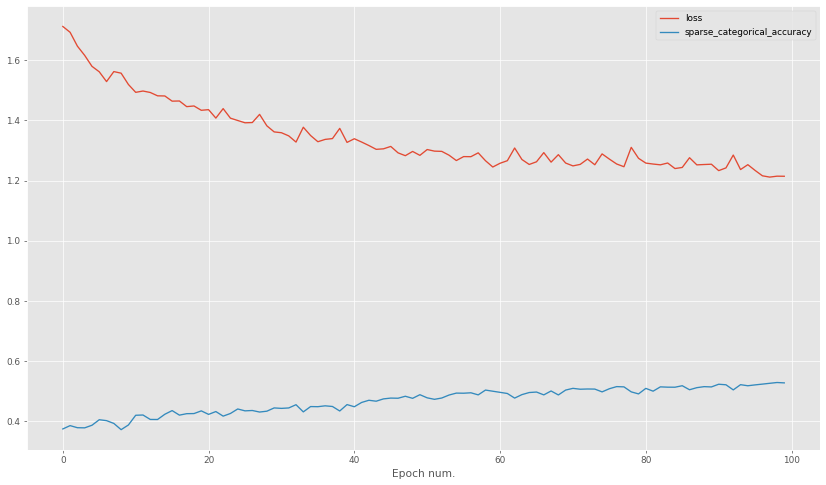

In [19]:
history = model.fit(x_train, y_train, epochs=100, verbose=0)
pd.DataFrame(history.history).plot()
plt.xlabel('Epoch num.')
plt.show()

Hemos realizado 100 epochs a partir del modelo ya entrenado y parece que, aunque sigue evolucionando, su capacidad predictiva deja un poco que desear. Vamos a entrenar un modelo un poco más complejo a ver si somos capaces de que la precisión aumente.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(5, activation='sigmoid'),
    tf.keras.layers.Dense(5, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax'),
])
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.SGD(),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)
model.summary()

Para el entrenamiento vamos a hacer uso de un argumento más, `validation_split=0.1`. Con este argumento el conjunto de entrenamiento se separará en 2 conjuntos diferentes durante cada _epoch_: uno con el 90% de los datos, con el que se realizará el entrenamiento y otro con el 10% de datos restante para evaluar la red tras el entrenamiento de ese epoch. Vamos allá:

In [ ]:
history = model.fit(x_train, y_train, epochs=100, validation_split=0.1)

Con este argumento podemos ser capaces de tener una intuición no solo de cómo va aprendiendo la red, sino de su evolución en la capacidad de predicción.

In [ ]:
pd.DataFrame(history.history).plot()
plt.xlabel('Epoch num.')
plt.show()

Un entrenamiento que tiene mejor pinta. parece que más o menos el modelo acierta un 77% de los casos en entrenamiento y un 74% de los casos en validación. No es una diferencia muy grande, así que podemos decir que no está sobreespecializado (sufriendo _overfitting_).

Si damos como bueno este modelo, el siguiente (y último paso) para determinar si es apto para usarse en el mundo real sería comprobar con el conjunto de test. Veamos como se comporta con este:

In [ ]:
model.evaluate(x_test, y_test)

Aproximadamente un 75% de exactitud, no está mal. O no. Todo depende del problema, ya que un 75% de aciertos en reconocer un cáncer de mama no es una estadística muy halagüeña. Pero no nos preocupemos, hay más modelos que aprenderemos para abordar diferentes casos. Por ahora, estamos aprendiendo las diferentes formas de aprender modelos con Keras. Vamos a por la segunda forma.

## El API funcional

Muchos modelos de aprendizaje profundo son grafos acíclicos dirigidos (DAG, del inglés _directed acyclic graph_) donde cada nodo se corresponde con una capa. El API funcional nos permite construirlos en términos de entradas y salidas de capas.

Esto es debido a que, en el momento que queremos interconectar las capas de una manera diferente (por ejemplo una entrada común que va a dos subredes independientes que luego convergen en una capa común), el API secuencial no nos sirve.

Nos encontraremos con redes complicadas de este tipo más adelante. Por ahora nos ceñiremos a nuestro perceptrón multicapa y su definición con este API. Veamos cómo sería:

In [ ]:
# Definimos las capas con sus conexiones explícitamente
input_layer = tf.keras.layers.Input(shape=(28, 28))
flatten = tf.keras.layers.Flatten()(input_layer)
hidden_1 = tf.keras.layers.Dense(5, activation='sigmoid')(flatten)
hidden_2 = tf.keras.layers.Dense(5, activation='sigmoid')(hidden_1)
output_layer = tf.keras.layers.Dense(10, activation='softmax')(hidden_2)
# Creamos el modelo especificando cuáles son las entradas y cuáles las salidas
model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
# La arquitectura ya está definida, así que ya podemos compilarlo
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.SGD(),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)
model.summary()

Exactamente los mismos parámetros y la misma arquitectura, sólo que definido de manera diferente. Ahora vamos a realizar un nuevo entrenamiento para ver si la tendencia es similar a la anterior (que esperemos que lo sea):

In [ ]:
history = model.fit(x_train, y_train, epochs=100, validation_split=0.1)

Desde luego por los valores de los indicadores en entrenamiento y en validación, parece que se está comportando de la misma manera. Veamos la tendencia en una gráfica, que siempre es más agradecida.

In [ ]:
pd.DataFrame(history.history).plot()
plt.xlabel('Epoch num.')
plt.show()

En efecto, se parecen bastante. Y menos mal, porque si no todo esto no valdría para nada. Ya conocemos las dos formas que tiene Keras para definir modelos de redes neuronales.

## Conclusiones

Con esto concluimos la implementación mediante dos API diferentes, la API secuencial y la API funcional. Ambas dos son **declarativas**, es decir:

1. Se declara primero qué capas se van a usar y cómo se conectan (esto último implícito en el caso de la API secuencial)
2. Posteriormente se alimenta al modelo con algunos datos para su entrenamiento.

Esto tiene una gran desventaja para un caso concreto: ¿qué ocurre si queremos un modelo dinámico? ¿Modelos que requieran bucles a lo largo de sus datos, bifuraciones que sólo se activan bajo determinadas condiciones? Una vez el modelo se crea, con las API explicadas este permanece estático.

Estos casos son los que se intentan cubrir en el modo de creación mediante herencia directa de la clase `Model`, también conocido como _Subclassing API_ [1]. Con él pasamos de un paradigma declarativo a uno **imperativo** de creación de modelos.

Este modo es más complejo, pero os animamos a que experimentéis si os gusta. Y si queréis colaborar con el contenido de la asignatura, ¡estáis a un _pull request_ de hacerlo!

---

## Referencias


[1] Guía para la creación de capas y modelos personalizados (<https://www.tensorflow.org/guide/keras/custom_layers_and_models>)

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>